In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import trange
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow.python import debug as tf_debug
tfd = tfp.distributions
tf.keras.backend.clear_session()  # For easy reset of notebook state.


2023-09-22 17:04:13.762321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
tf.__version__

'2.2.0'

In [2]:
tfp.__version__

'0.18.0'

In [16]:
def encoder(latent_dim):

    encoder_input = keras.Input(shape=(28, 28, 1))

    x = layers.Conv2D(16, (3,3), 2, 'SAME', activation='relu')(encoder_input)
    x = layers.Conv2D(32, (3,3), 2, 'SAME', activation='relu')(encoder_input)
    x = layers.Conv2D(64, (3,3), 2, 'SAME', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(2*latent_dim)(x)

    encoder_output = x 
    Encoder = keras.Model(encoder_input, encoder_output, name='encoder_VAE_MNIST')
    return Encoder, encoder_output


In [17]:
latent_dim = 8

In [19]:
Encoder, encoder_output = encoder(latent_dim)
Encoder.summary()

Model: "encoder_VAE_MNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_3 (Dense)             (None, 16)                50192     
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
Total params: 69,280
Trainable params: 69,280
Non

In [20]:
def decoder(encoder_output, latent_dim):

    decoder_input = keras.Input(shape=encoder_output.shape[1:]) #ignore batch size
    print(decoder_input)
    x = tfp.layers.DistributionLambda(make_distribution_fn=lambda t:\
             tfd.MultivariateNormalDiag(loc=t[..., :latent_dim], scale_diag=tf.exp(t[..., latent_dim:])),
             convert_to_tensor_fn=lambda s: s.sample())(decoder_input)
    
    z_mean = decoder_input[..., :latent_dim]
    z_log_var = decoder_input[..., latent_dim:]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # reparametrization trick
    x = z_mean + tf.exp(0.5 * z_log_var) * epsilon


    x = layers.Dense(7 * 7 * 64, activation='relu')(x)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2D(1, 3, activation='sigmoid', strides=1, padding='same')(x)
#     out_2 = layers.Conv2D(1, 3, activation='sigmoid', strides=1, padding='same')(x)
    decoder_output = x
    Decoder = keras.Model(inputs=decoder_input, outputs=x, name='decoder_VAE_MNIST')
    return Decoder

In [22]:
Decoder = decoder(encoder_output, latent_dim)
Decoder.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'")
Model: "decoder_VAE_MNIST"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 8)           0           ['input_6[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_5 (Sl  (None, 8)           0           ['input_6[0][0]']                
 icingOpLambda)                      

In [23]:
VAE_input = keras.Input(shape=(28, 28, 1))

encoded_img = Encoder(VAE_input)

decoded_img = Decoder(encoded_img)

VAE_output = [decoded_img, encoded_img]

model = keras.Model(inputs=VAE_input, outputs=VAE_output, name='mnist_vae')
model.summary()

Model: "mnist_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder_VAE_MNIST (Function  (None, 16)               69280     
 al)                                                             
                                                                 
 decoder_VAE_MNIST (Function  (None, 28, 28, 1)        83905     
 al)                                                             
                                                                 
Total params: 153,185
Trainable params: 153,185
Non-trainable params: 0
_________________________________________________________________


In [24]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(128)


In [25]:
def loss_fn(y_true, y_predict):
    
    reconstruct = y_predict[0]
    rec_loss_batch = tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, reconstruct), axis=[1, 2])
    rec_loss = tf.reduce_mean(rec_loss_batch)
    
    z_mean, z_sigma = y_predict[1][:, :latent_dim], y_predict[1][:, latent_dim:]
    kl_loss_batch = -0.5 * tf.reduce_sum(z_sigma - tf.square(z_mean) - tf.exp(z_sigma) + 1, axis=1)
    kl_loss = tf.reduce_mean(kl_loss_batch)
    loss = rec_loss + 10 * kl_loss
    
    return loss, rec_loss, kl_loss


test_train = []


@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        prediction = model(x)
        tot_loss, rec_loss, kl_loss = loss_fn(x, prediction)
        
        grads = tape.gradient(tot_loss, model.trainable_variables)
        
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return tot_loss, rec_loss, kl_loss


In [26]:
tot_loss_results = []
rec_loss_results = []
kl_loss_results = []

In [27]:
nb_epochs = 10
optimizer = keras.optimizers.Adam(learning_rate=0.005)

t = trange(nb_epochs, desc='Convo VAE')


''' Training Loop'''
for epoch in t:
    epoch_loss_avg = tf.keras.metrics.Mean()
    for i, features in enumerate(x_train):
        losses = train_step(features)
        tot_loss_results.append(losses[0])
        rec_loss_results.append(losses[1])
        kl_loss_results.append(losses[2])
    # if epoch in liste_save:
        # test_train.append(model(np.expand_dims(x_test[-1], axis=0))[0].numpy().reshape(28, 28))

    t.set_description('Conv VAE, loss=%g' % tot_loss_results[-1])


Conv VAE, loss=206.802: 100%|██████████| 10/10 [11:15<00:00, 67.55s/it]


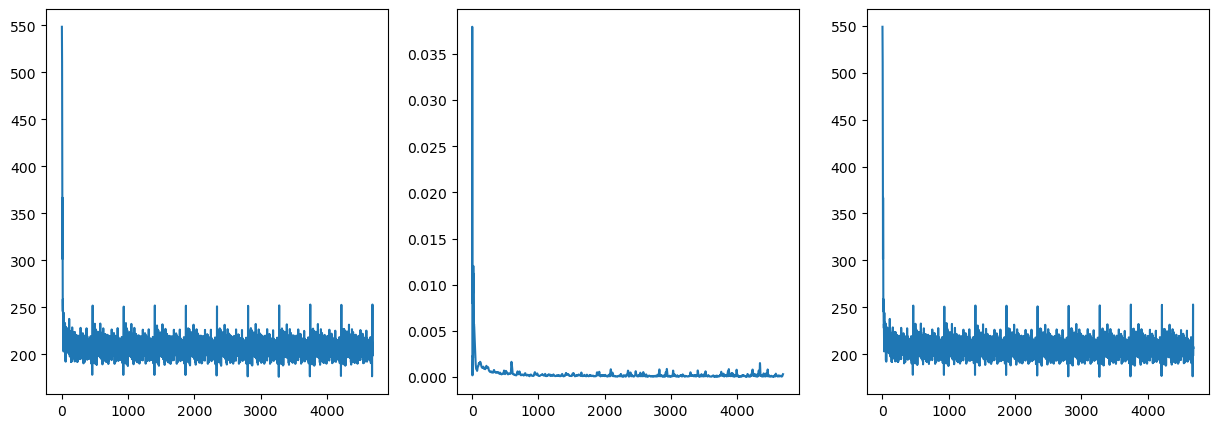

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(np.arange(len(rec_loss_results)), rec_loss_results)
ax[1].plot(np.arange(len(kl_loss_results)), kl_loss_results)
ax[2].plot(np.arange(len(tot_loss_results)), tot_loss_results)


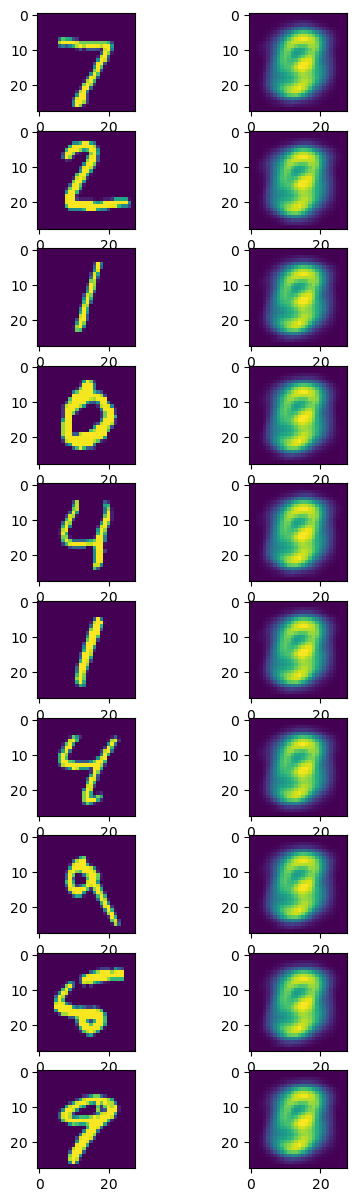

In [29]:
fig, ax = plt.subplots(10, 2, figsize=(5, 15))
for i in range(10):
    ax[i, 0].imshow(x_test[i])
    ax[i, 1].imshow(model(x_test[i:i+1])[0].numpy()[0, :, :, 0])

IndexError: list index out of range

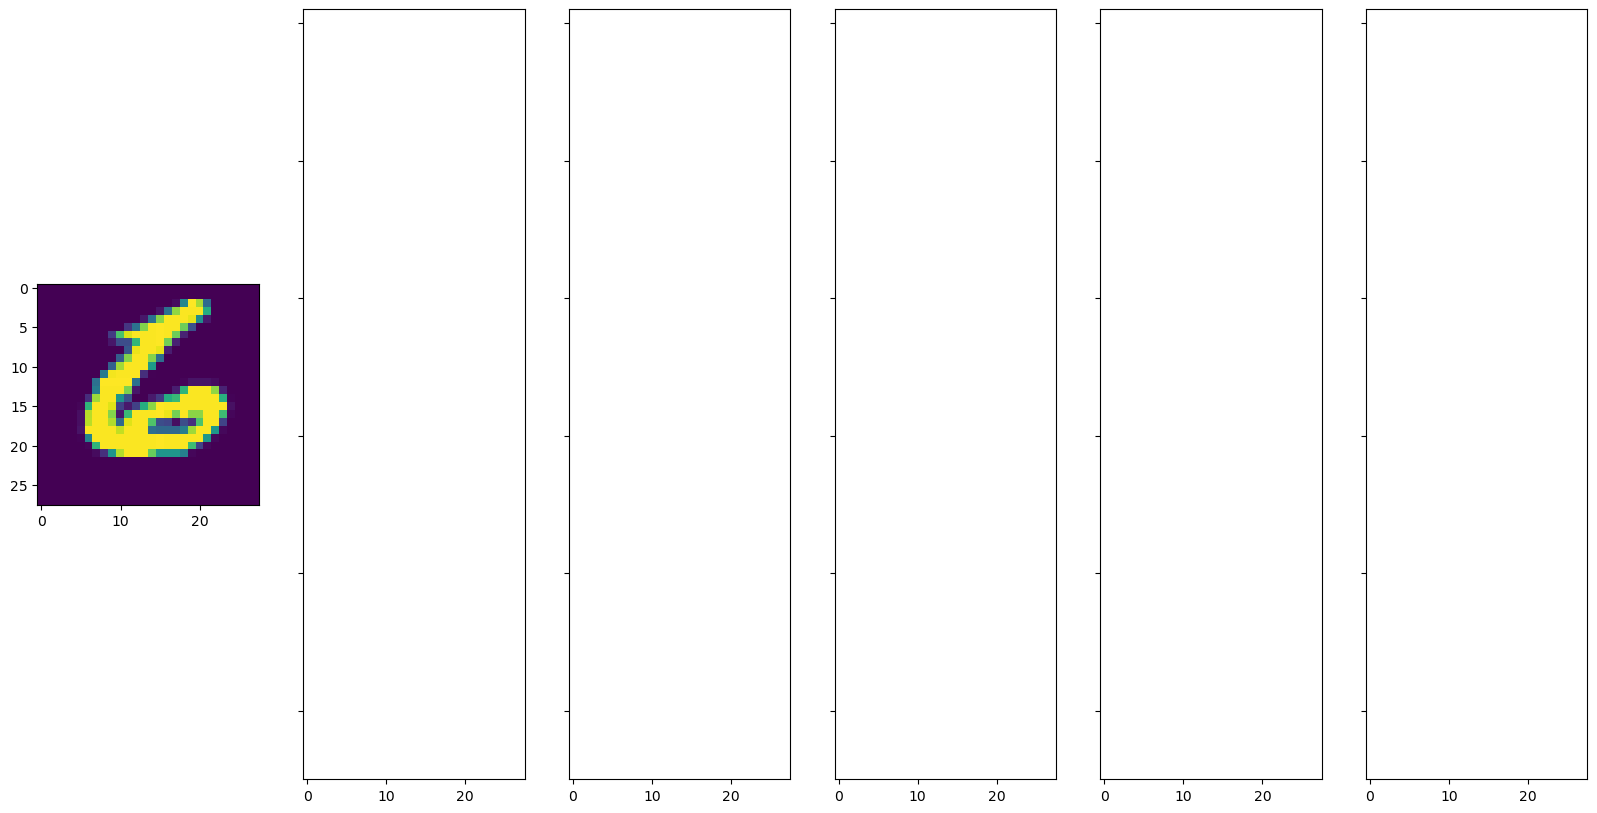

In [30]:
fig, ax = plt.subplots(1, 6, figsize=(20,10), sharex=True, sharey=True)
ax = ax.flatten()
ax[0].imshow(x_test[-1, :, :, 0])
for j, i in enumerate(np.arange(4)):
    ax[j+1].imshow(test_train[i])
ax[-1].imshow(test_train[-1])    

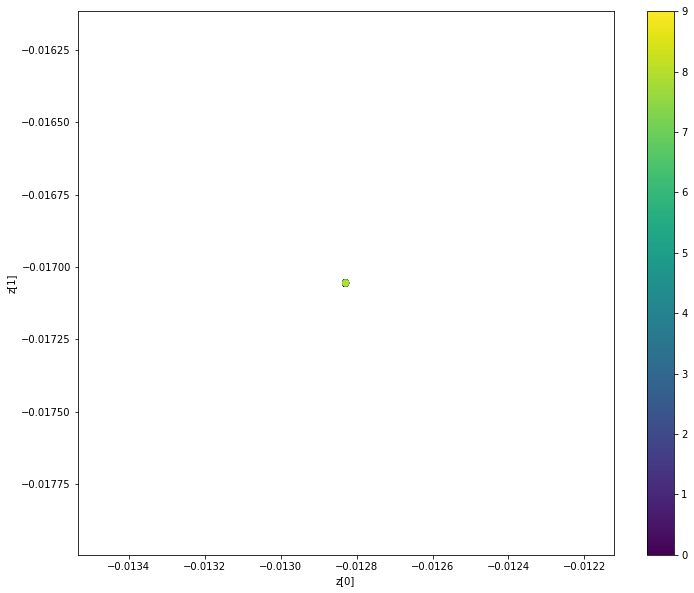

In [44]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    encoded = encoder.predict(data)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(encoded[:, 0], encoded[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(Encoder, x_train, y_train)


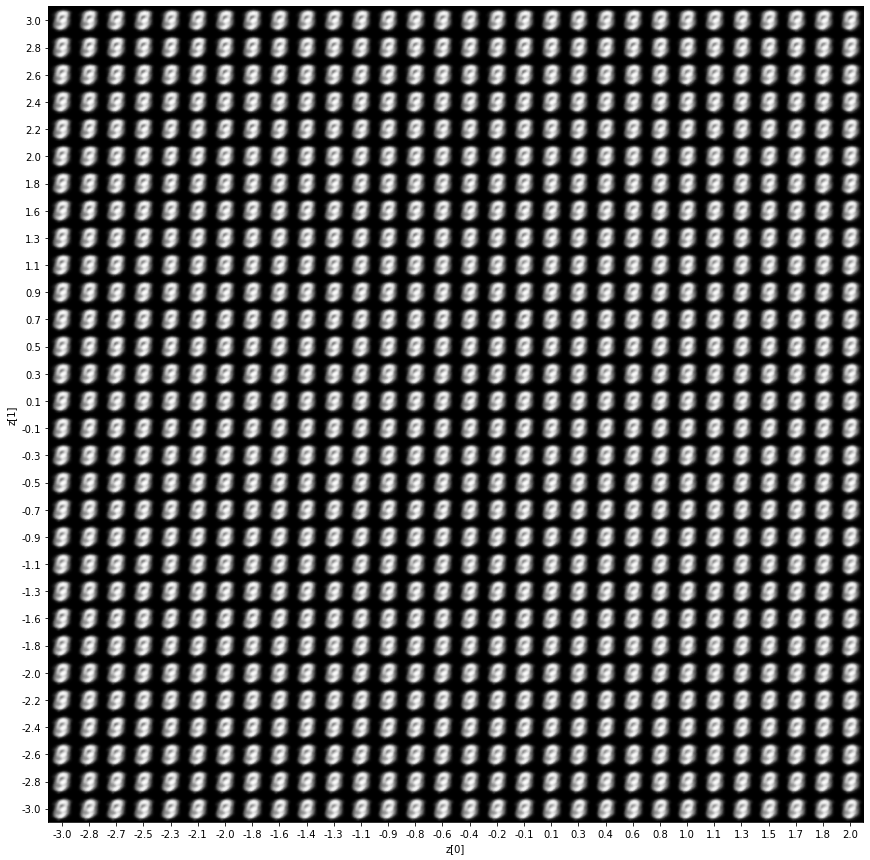

In [45]:
def plot_latent_space(decoder, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scales0 = [-3, 2]
    scales1 = [-3, 3]

    grid_x = np.linspace(scales0[0], scales0[1], n)
    grid_y = np.linspace(scales1[0], scales1[1], n)[::-1]
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            
            
            z_sample = np.zeros((1, 4))
            z_sample[0]= [xi, yi, 0, 0]
            x_decoded = decoder(z_sample)
            digit = x_decoded[0, :, :, 0]
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(Decoder)

In [18]:
plt.scatter(np.array(zs)[:, 0], np.array(zs)[:, 1], c=y_train[:nb_to_plot])
plt.colorbar()

NameError: name 'zs' is not defined

In [ ]:
# for i in range(len(test_train))[::10]:
#     plt.imshow(test_train[i])
#     plt.savefig(f'./training_img/mnist_training{i}')

In [ ]:
import glob
import moviepy.editor as mpy
import re


def sort_nicely(l):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    l.sort(key=alphanum_key)
    return l


path = './training_img/'
gif_name = 'train_vae'
fps = 3
print(path+'training*')
file_list = glob.glob(path+'*.png')
file_list = sort_nicely(file_list)
print(f' number of files : {len(file_list)}')

clip = mpy.ImageSequenceClip(file_list, fps=fps)
clip.write_gif('{}.gif'.format(path+gif_name), fps=fps)


In [ ]:
x = np.random.uniform(0, 1, (100, 20))
plt.imshow(x, cmap='gray')
plt.xticks([])
plt.yticks([])